<a href="https://colab.research.google.com/github/Spookytober/Datascience/blob/main/Aubr_OrfU5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 5 Project: How Much Alcohol do US States Drink?




In [ ]:
#Imports needed
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import arviz as az
import pymc as pm
import xarray as xr
from scipy.interpolate import PchipInterpolator

For my Unit 5 project, I will be trying to predict how US state population affects alcohol consumption. I found my dataset on the National Institute of Alcohol Abuse and Alcoholism, and it contains a list of states, their populations in 2022, and the amount of ethanol consumed in thousands of gallons.

In [ ]:
alcohol = pd.read_csv("https://raw.githubusercontent.com/Spookytober/Datascience/refs/heads/main/population%20v%20ethanol%20consumption%20-%20Sheet1.csv")
alcohol

,State,Pop,Ethanol
0,Alabama,5073903,8459
1,Alaska,733276,1675
2,Arizona,7365684,14815
3,Arkansas,3046404,4867
4,California,39040616,93912
5,Colorado,5841039,15133
6,Connecticut,3608706,7384
7,Delaware,1019459,3499
8,District of Columbia,670949,2333
9,Florida,22245521,56406


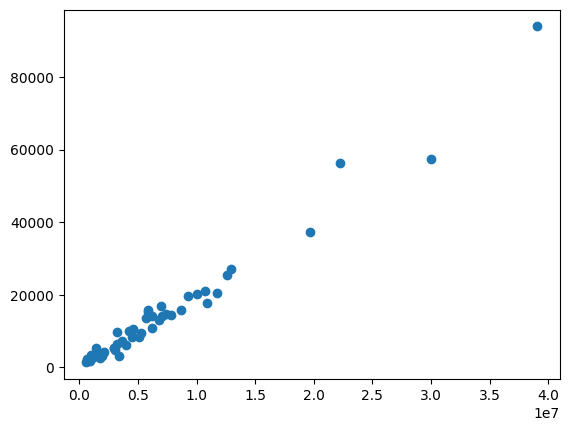

In [ ]:
plt.scatter(alcohol['Pop'],alcohol['Ethanol'])

I ran a scatterplot to see if there was any trend that was easy to see, and there was a very direct relationship between population size and alcohol consumption. I decided to start off my models by using a Normal distribution, because they usually are a good starting point.

In [ ]:
with pm.Model() as model_alcln:
    α = pm.Normal("α", mu=0, sigma=10)
    β = pm.Normal("β", mu=0, sigma=10)
    μ = pm.Deterministic("μ", α + β * alcohol.Pop)
    σ = pm.HalfCauchy("σ", 10)
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed= alcohol.Ethanol)
    idata_alcln = pm.sample()

Output()

Output()

Text(0, 0.5, 'Ethanol')

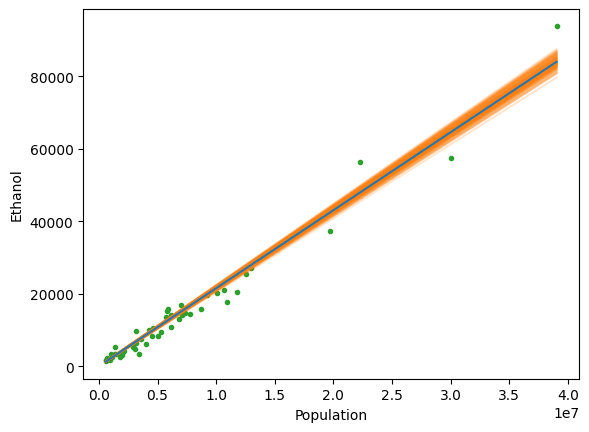

In [ ]:
posterior = az.extract(idata_alcln, num_samples=100)
x_plot = xr.DataArray(
    np.linspace(alcohol.Pop.min(), alcohol.Pop.max(), 50),
    dims="plot_id"
    )
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot
lines = posterior["α"] + posterior["β"] * x_plot
_, ax = plt.subplots()
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")
ax.plot(x_plot, mean_line, c="C0", label="mean line")
ax.plot(alcohol.Pop, alcohol.Ethanol, "C2.", zorder=-3)
ax.set_xlabel("Population")
ax.set_ylabel("Ethanol")

In [ ]:
pm.sample_posterior_predictive(idata_alcln, model=model_alcln,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'eth')

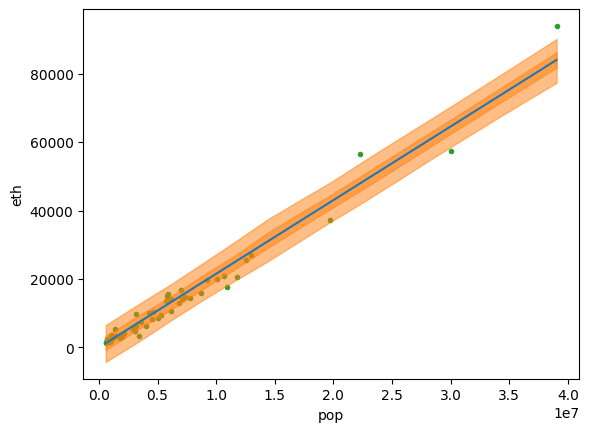

In [ ]:
mean_line = idata_alcln.posterior["μ"].mean(("chain", "draw"))
pops = np.random.normal(alcohol.Pop.values, 0.01)
idx = np.argsort(pops)
x = np.linspace(pops.min(), pops.max(), 15)
y_pred_q = idata_alcln.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(pops[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)
_, ax = plt.subplots()
ax.plot(alcohol.Pop, alcohol.Ethanol, "C2.", zorder=-3)
ax.plot(alcohol.Pop[idx], mean_line[idx], c="C0")
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)
ax.set_xlabel("pop")
ax.set_ylabel("eth")

The posterior here didn't look too bad, but a being a perfecctly straight line caused some issues with the data as it went closer to zero. parts of the line went below zero on the graph, which means negative gallons of alcohol would be consumed. Last I checked, that was physically impossible, so the Normal distribution has an issue there. The posterior predictive check below goes past zero, which makes sense because Normal distributions have no such limitation on the x-axis.

<Axes: xlabel='y_pred'>

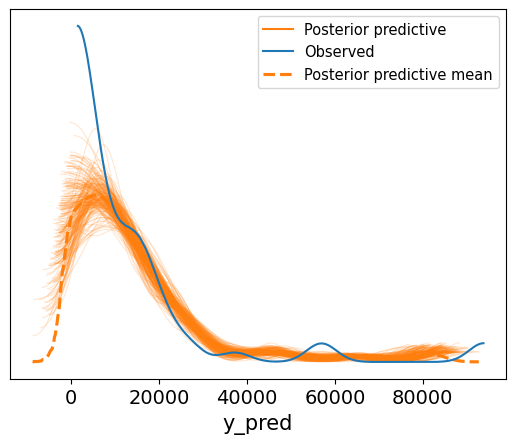

In [ ]:
az.plot_ppc(idata_alcln, num_pp_samples=200, colors=["C1", "C0", "C1"])

The Normal distribution performed okay, but because of its ability to go past 0 it screwed up the data. At this point I remembered the negative binomial model that was used in the notes for the bikes, and I thought that it could be used for this data set.

In [ ]:
with pm.Model() as model_alcnb:
    α = pm.Normal("α", mu=0, sigma=1)
    β = pm.Normal("β", mu=0, sigma=10)
    μ = pm.Deterministic("μ", α + β * alcohol.Pop)
    σ = pm.HalfNormal("σ", 10)
    y_pred = pm.NegativeBinomial("y_pred", mu=μ, alpha=σ, observed=alcohol.Ethanol)
    idata_alclnb = pm.sample()

Output()

Output()

Output()

<Axes: xlabel='y_pred'>

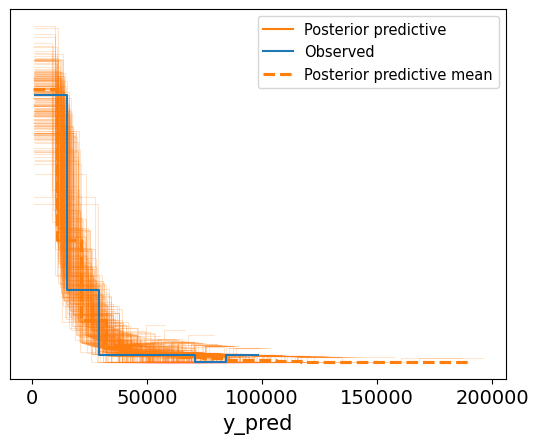

In [ ]:
pm.sample_posterior_predictive(idata_alclnb, model = model_alcnb, extend_inferencedata=True)
az.plot_ppc(idata_alclnb, num_pp_samples=200, colors=["C1", "C0", "C1"])

Text(0, 0.5, 'Ethanol')

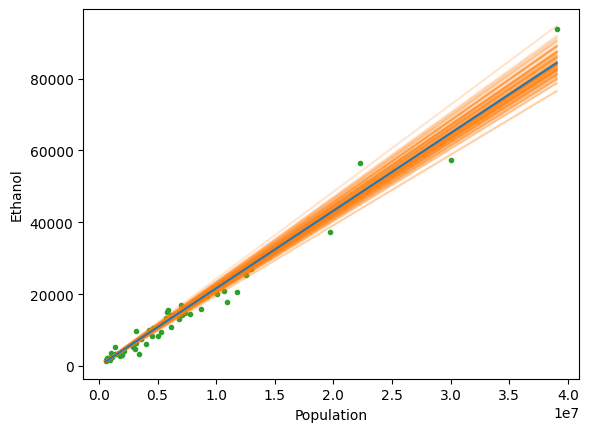

In [ ]:
posterior = az.extract(idata_alclnb, num_samples=100)
x_plot = xr.DataArray(
    np.linspace(alcohol.Pop.min(), alcohol.Pop.max(), 50),
    dims="plot_id"
    )
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot
lines = posterior["α"] + posterior["β"] * x_plot
_, ax = plt.subplots()
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")
ax.plot(x_plot, mean_line, c="C0", label="mean line")
ax.plot(alcohol.Pop, alcohol.Ethanol, "C2.", zorder=-3)
ax.set_xlabel("Population")
ax.set_ylabel("Ethanol")

Text(0, 0.5, 'Ethanol (kGal)')

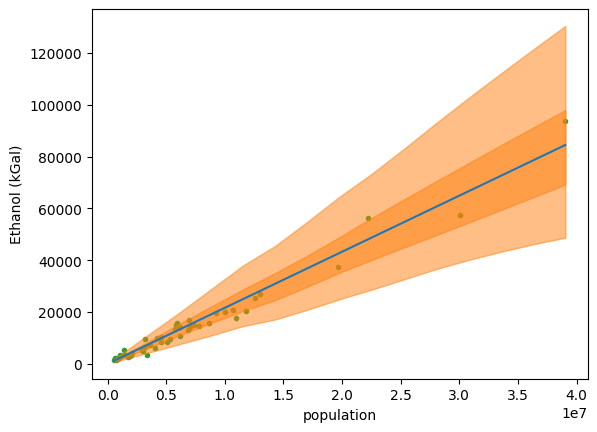

In [ ]:
mean_line = idata_alclnb.posterior["μ"].mean(("chain", "draw"))
pops = np.random.normal(alcohol.Pop.values, 0.01)
idx = np.argsort(pops)
x = np.linspace(pops.min(), pops.max(), 15)
y_pred_q = idata_alclnb.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(pops[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(alcohol.Pop, alcohol.Ethanol, "C2.", zorder=-3)
ax.plot(alcohol.Pop[idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("population")
ax.set_ylabel("Ethanol (kGal)")

The Negative Binomial model performed fairly well. Because it couldn't go past zero, the posterior predictive check itself was good, but its uncertainty on the graphed posterior towards the higher numbers made me want to search for a better distribution to use. I decided, based on looking at the observed data in the posterior predictives, that a HalfNormal might work. The distribution doesn't extend into negative values.

In [ ]:
with pm.Model() as model_alclhn:
    α = pm.Normal("α", mu=0, sigma=10)
    β = pm.Normal("β", mu=0, sigma=10)
    μ = pm.Deterministic("μ", α + β * alcohol.Pop)
    σ = pm.HalfCauchy("σ", 10)
    y_pred = pm.HalfNormal("y_pred", sigma=μ, observed= alcohol.Ethanol)
    idata_alclhn = pm.sample()

Output()

Output()

Text(0, 0.5, 'Ethanol')

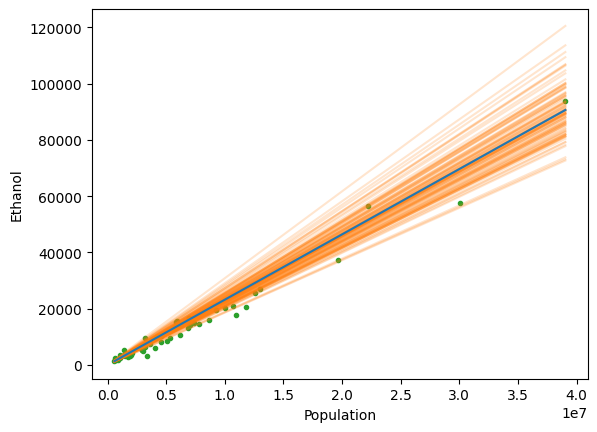

In [ ]:
posterior = az.extract(idata_alclhn, num_samples=100)
x_plot = xr.DataArray(
    np.linspace(alcohol.Pop.min(), alcohol.Pop.max(), 50),
    dims="plot_id"
    )
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot
lines = posterior["α"] + posterior["β"] * x_plot
_, ax = plt.subplots()
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")
ax.plot(x_plot, mean_line, c="C0", label="mean line")
ax.plot(alcohol.Pop, alcohol.Ethanol, "C2.", zorder=-3)
ax.set_xlabel("Population")
ax.set_ylabel("Ethanol")

Output()

<Axes: xlabel='y_pred'>

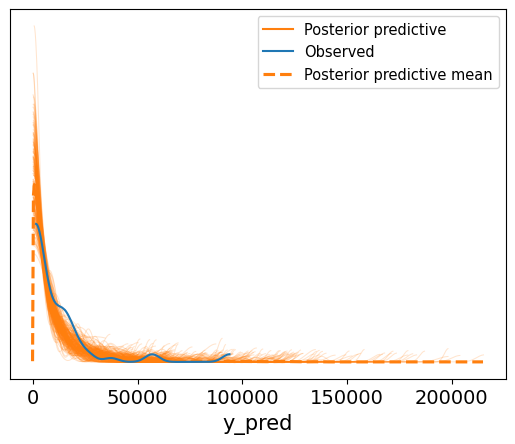

In [ ]:
pm.sample_posterior_predictive(idata_alclhn, model = model_alcln, extend_inferencedata=True)
az.plot_ppc(idata_alcln, num_pp_samples=200, colors=["C1", "C0", "C1"])

Text(0, 0.5, 'eth')

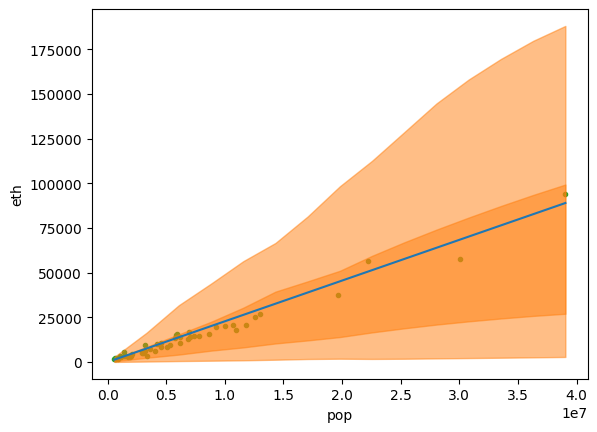

In [ ]:
mean_line = idata_alclhn.posterior["μ"].mean(("chain", "draw"))
pops = np.random.normal(alcohol.Pop.values, 0.01)
idx = np.argsort(pops)
x = np.linspace(pops.min(), pops.max(), 15)
y_pred_q = idata_alcln.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(pops[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)
_, ax = plt.subplots()
ax.plot(alcohol.Pop, alcohol.Ethanol, "C2.", zorder=-3)
ax.plot(alcohol.Pop[idx], mean_line[idx], c="C0")
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)
ax.set_xlabel("pop")
ax.set_ylabel("eth")

Both the graph and the posterior predictive check were worse than any previous iteration. The PPC predicted a much higher amount of everything, with samples fraying off of the posterior predictive mean. The graph for the half normal said that there was a decent chance of a state with 40 million people drinking nearly 200,000,000 gallons of ethanol in a year as opposed to the half of that that California actually drinks.

It was at this point when I was frustrated with the lack of a good fit. I asked Mr. Arredondo for help, and he suggested a Gamma distribution. I immediately kicked myself for not trying that sooner, because the Gamma was exactly what I needed. The limit of positive x-values and its ability to model skew made it work.

In [ ]:
with pm.Model() as model_alcgam:
  a = pm.Normal("a", mu = 0, sigma = 1)
  b = pm.Normal("b", mu = 0, sigma = 1)
  u = pm.Deterministic("u", a + b * alcohol.Pop)
  s = pm.HalfCauchy("s", 10)
  y_pred = pm.Gamma("y_pred", mu = u, sigma = s, observed = alcohol.Ethanol)
  idata_alcgam = pm.sample()

Output()

Output()

Output()

<Axes: xlabel='y_pred'>

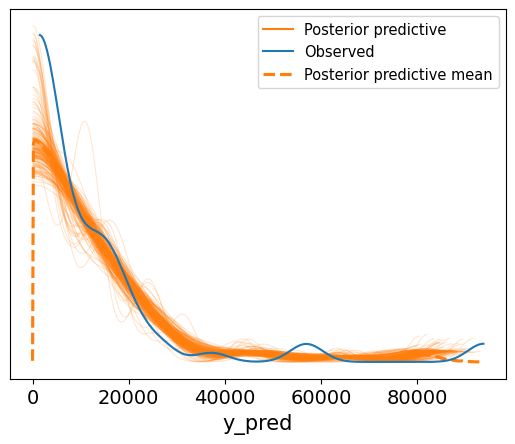

In [ ]:
pm.sample_posterior_predictive(idata_alcgam, model = model_alcgam, extend_inferencedata=True)
az.plot_ppc(idata_alcgam, num_pp_samples=200, colors=["C1", "C0", "C1"])

Text(0, 0.5, 'eth')

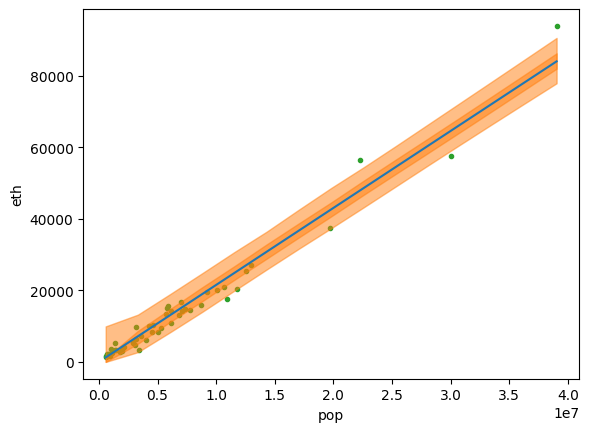

In [ ]:
mean_line = idata_alcgam.posterior["u"].mean(("chain", "draw"))
pops = np.random.normal(alcohol.Pop.values, 0.01)
idx = np.argsort(pops)
x = np.linspace(pops.min(), pops.max(), 15)
y_pred_q = idata_alcgam.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(pops[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)
_, ax = plt.subplots()
ax.plot(alcohol.Pop, alcohol.Ethanol, "C2.", zorder=-3)
ax.plot(alcohol.Pop[idx], mean_line[idx], c="C0")
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)
ax.set_xlabel("pop")
ax.set_ylabel("eth")

The posterior predictive check and the graph for the gamma distribution were both better than any of the other attempted distributions. The graph was confient with its trend line, and it didn't ever go below zero. the PPC matched the data extremely well, with many posterior predictive samples following the observed data almost perfectly. The gamma distribution was the best fitting distribution for this dataset.



---



---



"Fun" little ending stats:

The average ethanol consumption, according to my data, was about 2.42 gallons per person per year in 2022. According to the NIAAA, an "average drink" contains about 0.6 fluid ounces of ethanol, which means that in order to consume those 2.42 gallons, each person over the age of 21 must drink 516 "average" drinks.

The state with the highest ethanol consumption per capita is New Hampshire, and the state with the least ethanol consumption per capita is Utah.